# Order Reviews Exploratory Data Analysis

In this project, I'll be exploring a Brazilian e-commerce public dataset of orders made at Olist Store available on [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce). The dataset has information on 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil.

In my other project ([olist-public](https://github.com/kimurarh/olist-public)) I have conducted a more detailed exploratory analysis on all datasets made publicly available by Olist. Here, as we'll only work with textual data on order reviews, I will only conduct a brief exploratory analysis on the `Order Reviews` dataset.

### Importing Libraries

In [1]:
import zipfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageOps

import nltk
from nltk.corpus import stopwords

# seaborn config
sns.set(font_scale=1.2)
sns.set_palette("pastel")

# Defining some colors
gray = "#9E9E9E"
blue = "#4285F4"

## 1. Exploratory Data Analysis (EDA)
___

### Loading Data

In [2]:
# Reading the zipfile containing the datasets
zf = zipfile.ZipFile("data/olist-datasets.zip")

# Loading the order reviews dataset
reviews_df = pd.read_csv(zf.open("olist_order_reviews_dataset.csv"),
                         parse_dates=['review_creation_date', 
                                      'review_answer_timestamp'])

In [3]:
print(f"Dimensions: {reviews_df.shape}")
display(reviews_df.head(10))

Dimensions: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47


### 1.1 How often do people leave good reviews? (Review Score Distribution)

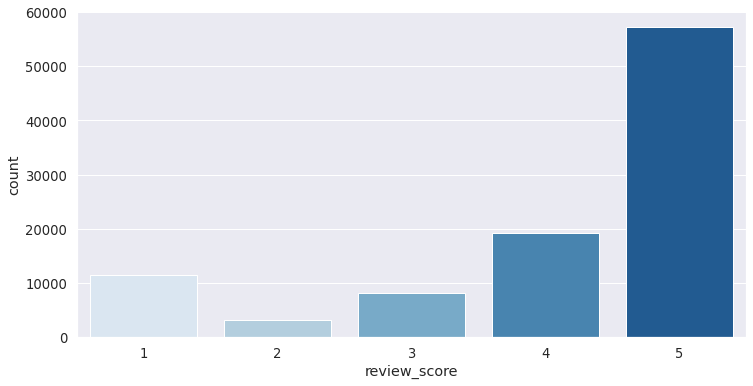

Percentage:
- ★★★★★: 57.78%
- ★★★★: 19.29%
- ★★★: 8.24%
- ★★: 3.18%
- ★: 11.51%


In [4]:
# Ploting review_score distribution
plt.figure(figsize=(12,6))
ax = sns.countplot(x="review_score", data=reviews_df.fillna('No_Review'), palette='Blues')
plt.show()

# Calculating percentage
perc_scores = reviews_df['review_score'].value_counts() / len(reviews_df) * 100
print("Percentage:")
for score in range(5, 0, -1):
    print(f"- {score*'★'}: {perc_scores[score]:2.2f}%")

**Most of the reviews (57.78%) are 5 stars**. But we can see a **significant number of bad reviews (1 star)**.

### 1.2 How often do clients write reviews/comments?

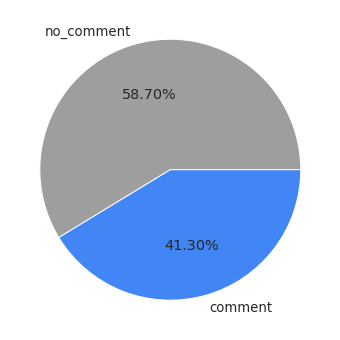

In [5]:
# Identifying if there is a comment message
reviews_df["comment_or_not"] = reviews_df["review_comment_message"].apply(lambda x: "no_comment" if x is np.NaN else "comment")

# Count comments
reviews_count = reviews_df["comment_or_not"].value_counts()

# Pie Chart
plt.figure(figsize=(14,6))
plt.pie(reviews_count, 
        labels = reviews_count.index,
        colors = [gray, blue],
        autopct='%.2f%%')
plt.show()

**More than half of the orders (58.7%) don't have a written review/comment.**

### 1.3 Are people more likely to write a comment when they give a good or bad review score?

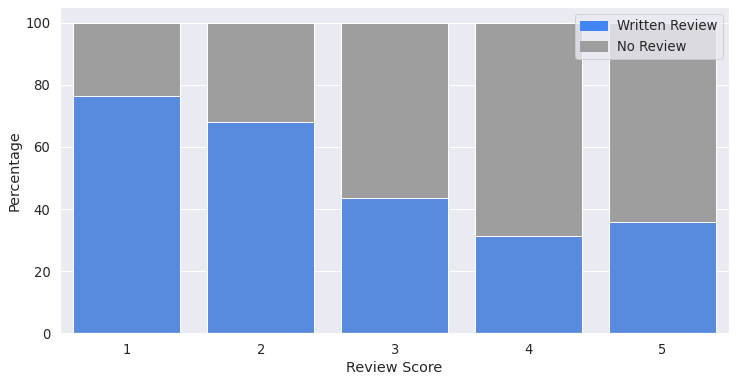

Probability of writing a review according to the review score:
- ★★★★★: 35.85%
- ★★★★: 31.22%
- ★★★: 43.49%
- ★★: 68.07%
- ★: 76.55%


In [6]:
# Grouping reviews
reviews_count = (reviews_df.groupby(["comment_or_not", "review_score"]).size()
                 .reset_index(name="count")
                 .pivot(index="review_score" ,columns='comment_or_not', values='count'))

# Calculating comment percentage
reviews_count["total"] = reviews_count[['comment', 'no_comment']].sum(axis=1)
reviews_count["comment_perc"] = reviews_count["comment"]/reviews_count["total"]*100

# Creating plot bars
plt.figure(figsize=(12, 6))
total_bar = sns.barplot(x=reviews_count.index, y=[100]*len(reviews_count), color=gray)
comment_bar = sns.barplot(x=reviews_count.index, y=reviews_count["comment_perc"], color=blue)

# add legend
blue_bar = mpatches.Patch(color=blue, label='Written Review')
gray_bar = mpatches.Patch(color=gray, label='No Review')
plt.legend(handles=[blue_bar, gray_bar], loc='upper right')

# Renaming labels
plt.xlabel('Review Score')
plt.ylabel('Percentage')

plt.show()

print("Probability of writing a review according to the review score:")
for score in range(5, 0, -1):
    print(f"- {score*'★'}: {reviews_count['comment_perc'][score]:2.2f}%")

As we can see in the chart above, **people are more likely to write a comment when they give a bad review score** (1 or 2).

### 1.4 Number of written reviews over the years

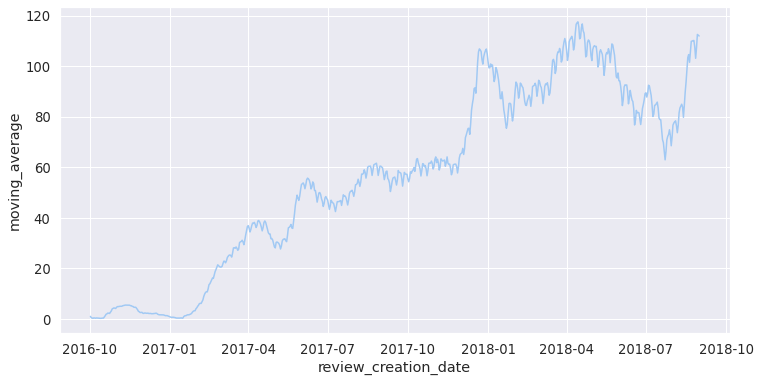

In [7]:
# Filtering written reviews
window_size = 30
reviews_dates = reviews_df[reviews_df['review_comment_message'].notna()][['review_creation_date']].copy()
reviews_dates.set_index("review_creation_date", inplace=True)

# Calculating moving average
reviews_dates = reviews_dates.resample("D").size().fillna(0).to_frame(name="num_reviews")
reviews_dates["moving_average"] = reviews_dates.rolling(window=window_size, min_periods=0).mean()

# Plot
plt.subplots(figsize=(12,6))
sns.lineplot(data=reviews_dates['moving_average'], sort=False)
plt.show()

### 1.5 What are the most frequent words in written reviews?

Let's create a wordcloud to represent the words that appear more frequently:

In [12]:
# Loading portuguese stopwords from nltk
nltk.download('stopwords')
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /home/kimura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


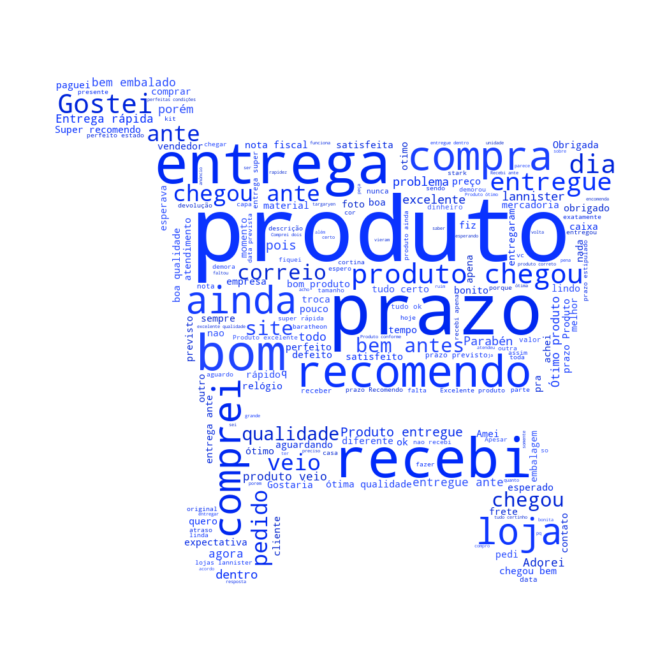

In [13]:
# Filtering only the orders with a written review
orders_written_reviews = reviews_df.query(f"review_comment_message.notna()", engine='python')

# Creating a mask image (shopping cart shape)
mask_image = np.array(Image.open("assets/shopping-cart.png"))
mask_image = np.ndarray((mask_image.shape[0], mask_image.shape[1]), np.int32)

# Transforming image for wordcloud
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

for i in range(len(mask_image)):
    mask_image[i] = list(map(transform_format, mask_image[i]))
    
# Defining a color function
def color_func(word, font_size, position,orientation, random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(40, 60))

# Creating wordcloud
wordcloud = (WordCloud(stopwords=stop_words,
                       background_color="white",
                       mask=mask_image,
                       color_func=color_func,
                       width=1600, height=800)
             .generate(' '.join(orders_written_reviews['review_comment_message']))
            )
fig = plt.figure(figsize=(20, 12))
fig = plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 1.6 What if we separate the reviews into positive and negative reviews? Do the same words appear in both visualizations?

In order to create these two visualizations, we'll separate the reviews as follows:
- **Positive Reviews**: `review_score >= 3`
- **Negative Reviews**: `review_score < 3`

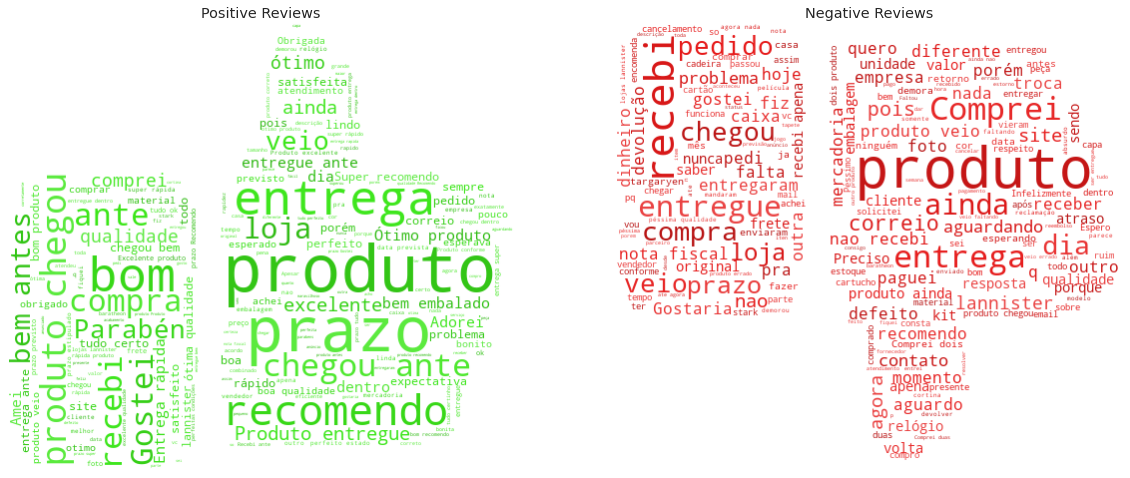

In [14]:
# Splitting into positive and negative reviews
positive_reviews = orders_written_reviews.query("review_score >= 3")
negative_reviews = orders_written_reviews.query("review_score < 3")

# Creating a mask image (like shape)
mask_image = np.array(Image.open("assets/like.png"))
mask_image = np.ndarray((mask_image.shape[0], mask_image.shape[1]), np.int32)

# Transforming image for wordcloud
for i in range(len(mask_image)):
    mask_image[i] = list(map(transform_format, mask_image[i]))

# Creating a inverted mask_image (for bad reviews)
mask_image_inv = np.flip(mask_image, 0)
    
# Defining a color function
def positive_color_func(word, font_size, position,orientation, random_state=None, **kwargs):
    return("hsl(470,80%%, %d%%)" % np.random.randint(40, 60))
def negative_color_func(word, font_size, position,orientation, random_state=None, **kwargs):
    return("hsl(0, 80%%, %d%%)" % np.random.randint(40, 60))

# Creating good reviews wordcloud
wc_positive = (WordCloud(stopwords=stop_words,
                         background_color="white",
                         mask=mask_image,
                         color_func=positive_color_func,
                         width=1600, height=800)
               .generate(' '.join(positive_reviews['review_comment_message']))
              )

# Creating bad reviews wordcloud
wc_negative = (WordCloud(stopwords=stop_words,
                         background_color="white",
                         mask=mask_image_inv,
                         color_func=negative_color_func,
                         width=1600, height=800)
               .generate(' '.join(negative_reviews['review_comment_message']))
              )

fig, axs = plt.subplots(1, 2, figsize=(20, 12))
axs[0].imshow(wc_positive, interpolation="bilinear")
axs[0].set_title("Positive Reviews")
axs[0].axis("off")
axs[1].imshow(wc_negative, interpolation="bilinear")
axs[1].set_title("Negative Reviews")
axs[1].axis("off");

Now that we've explored the data from written order reviews, let's start working with Natural Language Processing (NLP) techiniques and prepare our data to be used as inputs to a Machine Learning model. 